### Starbucks Capstone Challenge
# Model Training

This notebook aims to train the models proposed to classify offers as appropriate or not.

## Define functions to train the classifiers

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN, RecurrentNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [3]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, targets in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            valid_loss += criterion(prediction, targets)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(targets.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        # Calculate the metrics
        accuracy = metrics.accuracy_score(y_true, y_pred)
        c_matrix = metrics.confusion_matrix(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred)
        recall = metrics.recall_score(y_true, y_pred)

        model.train()

        return valid_loss, accuracy, precision, \
               recall, c_matrix

In [4]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        
        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

## Linear Classifier
This phase trains a feed-forward neural network to classify offer sending as appropriate or not.  
Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [5]:
linear_classifier = LinearNN(
    input_size=16, output_size=2, hidden_layers=[128,128,128])
criterion = nn.CrossEntropyLoss(
    torch.tensor([(42200. / 34072.), 1.]))
optimizer = optim.Adam(
    linear_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=15, verbose=True)

In [6]:
linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=150)

Epoch    1	train loss:  0.6419	valid loss:  0.6026
Epoch    2	train loss:  0.6010	valid loss:  0.5909
Epoch    3	train loss:  0.5942	valid loss:  0.5857
Epoch    4	train loss:  0.5899	valid loss:  0.5845
Epoch    5	train loss:  0.5871	valid loss:  0.5832
Epoch    6	train loss:  0.5862	valid loss:  0.5817
Epoch    7	train loss:  0.5864	valid loss:  0.5819
Epoch    8	train loss:  0.5841	valid loss:  0.5799
Epoch    9	train loss:  0.5834	valid loss:  0.5798
Epoch   10	train loss:  0.5820	valid loss:  0.5797
Epoch   11	train loss:  0.5815	valid loss:  0.5792
Epoch   12	train loss:  0.5811	valid loss:  0.5786
Epoch   13	train loss:  0.5805	valid loss:  0.5778
Epoch   14	train loss:  0.5801	valid loss:  0.5789
Epoch   15	train loss:  0.5795	valid loss:  0.5776
Epoch   16	train loss:  0.5790	valid loss:  0.5783
Epoch   17	train loss:  0.5791	valid loss:  0.5772
Epoch   18	train loss:  0.5789	valid loss:  0.5776
Epoch   19	train loss:  0.5769	valid loss:  0.5765
Epoch   20	train loss:  0.5774	

## Recurrent Classifier
This phase trains a recurrent neural network to classify offer sending as appropriate or not.  
This project proposes this model as the most suitable classification approach, considering the fact that the data is sequential.

In [7]:
recurrent_classifier = RecurrentNN(
    input_size=16, output_size=2, hidden_size=128, hidden_layers=2)
criterion = nn.CrossEntropyLoss(
    torch.tensor([(42200. / 34072.), 1.]))
optimizer = optim.Adam(
    recurrent_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=15, verbose=True)

In [8]:
recurrent_loss = train(recurrent_classifier,
                       model_name='recurrent_classifier',
                       epochs=150)

Epoch    1	train loss:  0.6572	valid loss:  0.6435
Epoch    2	train loss:  0.6291	valid loss:  0.6182
Epoch    3	train loss:  0.6100	valid loss:  0.6074
Epoch    4	train loss:  0.6046	valid loss:  0.6045
Epoch    5	train loss:  0.6016	valid loss:  0.6011
Epoch    6	train loss:  0.5982	valid loss:  0.5992
Epoch    7	train loss:  0.5957	valid loss:  0.5962
Epoch    8	train loss:  0.5944	valid loss:  0.5935
Epoch    9	train loss:  0.5925	valid loss:  0.5931
Epoch   10	train loss:  0.5917	valid loss:  0.5918
Epoch   11	train loss:  0.5905	valid loss:  0.5915
Epoch   12	train loss:  0.5901	valid loss:  0.5901
Epoch   13	train loss:  0.5895	valid loss:  0.5907
Epoch   14	train loss:  0.5890	valid loss:  0.5892
Epoch   15	train loss:  0.5887	valid loss:  0.5887
Epoch   16	train loss:  0.5880	valid loss:  0.5887
Epoch   17	train loss:  0.5880	valid loss:  0.5878
Epoch   18	train loss:  0.5877	valid loss:  0.5886
Epoch   19	train loss:  0.5877	valid loss:  0.5880
Epoch   20	train loss:  0.5872	

## Training phase results

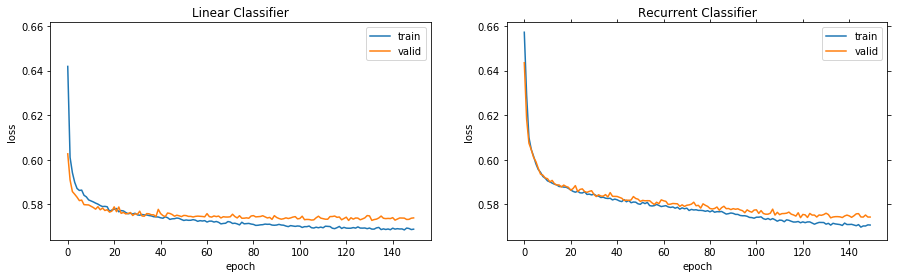

In [9]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(linear_loss[0], label='train')
ax0.plot(linear_loss[1], label='valid')
ax0.set_title('Linear Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(recurrent_loss[0], label='train')
ax1.plot(recurrent_loss[1], label='valid')
ax1.set_title('Recurrent Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.show()

## Test the trained models
Use unseen data to calculate metrics for both models.

In [10]:
## Load the saved models

# Linear
linear_classifier.load_state_dict(
    torch.load('linear_classifier.pt'))

# Recurrent
recurrent_classifier.load_state_dict(
    torch.load('recurrent_classifier.pt'))

print('Models loaded successfully')

Models loaded successfully


In [11]:
## Test models

l_loss, l_acc, l_prec, l_rec, l_cmatrix = \
    validate(linear_classifier, test_dataloader)

r_loss, r_acc, r_prec, r_rec, r_cmatrix = \
    validate(recurrent_classifier, test_dataloader)

### Compare results

In [12]:
def build_cmatrix(c_matrix, ax):
    ax.matshow(c_matrix, cmap='YlGn')
    ax.set_xlabel('Confusion Matrix')
    ax.text(0, 0, f'TN\n{c_matrix[0,0]}',
            ha="center", va="center", color="w")
    ax.text(0, 1, f'FP\n{c_matrix[0,1]}',
            ha="center", va="center", color="k")
    ax.text(1, 0, f'FN\n{c_matrix[1,0]}',
            ha="center", va="center", color="k")
    ax.text(1, 1, f'TP\n{c_matrix[1,1]}',
            ha="center", va="center", color="k")

,Linear Classifier,Recurrent Classifier
accuracy (%),67.97%,68.57%
precision,0.6742,0.6998
recall,0.5566,0.5269
loss,0.5646,0.5655


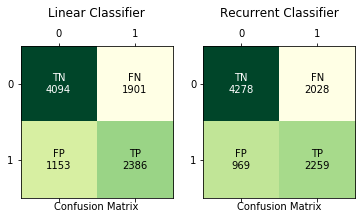

In [13]:
# Build the confusion matrix
fig, axs = plt.subplots(nrows=1, ncols=2)

build_cmatrix(l_cmatrix, axs[0])
axs[0].set_title('Linear Classifier\n')

build_cmatrix(r_cmatrix, axs[1])
axs[1].set_title('Recurrent Classifier\n')

# Table of results
result_df = pd.DataFrame(
    [[f'{l_acc*100:.2f}%', l_prec, l_rec, l_loss],
     [f'{r_acc*100:.2f}%', r_prec, r_rec, r_loss]],
    columns=['accuracy (%)', 'precision', 'recall', 'loss'],
    index=['Linear Classifier',
         'Recurrent Classifier']).T

# Display results
pd.set_option('display.precision', 4)
display(result_df)
plt.show()